In [1]:
import tensorflow as tf
import keras
import keras_cv
from keras import preprocessing
from functions import RandomResizedCrop, RandomColorJitter
tf.config.optimizer.set_jit(False)  # Desactivar XLA
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from Data import Data
from CreateModel import ModelCreate
import matplotlib.pyplot as plt
from keras import ops
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2024-07-03 20:51:06.522019: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 20:51:06.535604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 20:51:06.554448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 20:51:06.554473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 20:51:06.566903: I tensorflow/core/platform/cpu_feature_gua

In [2]:
X = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/square/train_val_test.npz')
images = X['data']
labels = np.argmax(X['labels'], axis=1)

ass = np.load('/home/aacastro/Alejandro/DQ_ACA_2024/C/data/square/assess.npz')
ass_f = ass['data']
ass_l = np.argmax(ass['labels'], axis=1)

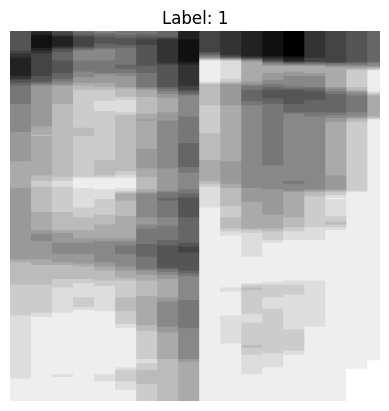

In [3]:
# Extraer una imagen y su etiqueta correspondiente
first_image = images[554]
first_label = labels[554]

# Visualizar la primera imagen
plt.imshow(first_image, cmap='gray')
plt.title(f'Label: {first_label}')
plt.axis('off')  # Ocultar los ejes
plt.show()

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 50

from functions import NNCLR
# hyperparameters
num_epochs = 100
steps_per_epoch = 20
width = 264
heigh = 264

# hyperparameters corresponding to each algorithm
hyperparams = {NNCLR: {"temperature": 0.1, "queue_size": 10000}}

In [5]:
# Dividir los datos en conjuntos de entrenamiento y prueba
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Dividir el conjunto de entrenamiento en datos etiquetados y no etiquetados
images_labeled_train, images_unlabeled_train, labels_labeled_train, _ = train_test_split(
    images_train, labels_train, test_size=0.2, random_state=42
)

def prepare_dataset():
    unlabeled_batch_size = len(images_unlabeled_train) // steps_per_epoch
    labeled_batch_size = len(images_labeled_train) // steps_per_epoch
    batch_size = unlabeled_batch_size + labeled_batch_size 
    print(unlabeled_batch_size)
    print(labeled_batch_size)
    # Crear datasets de TensorFlow
    unlabeled_train_dataset = (
        tf.data.Dataset.from_tensor_slices(images_unlabeled_train)
        .shuffle(buffer_size=shuffle_buffer)
        .batch(unlabeled_batch_size, drop_remainder=True)
    )
    labeled_train_dataset = (
        tf.data.Dataset.from_tensor_slices((images_labeled_train, labels_labeled_train))
        .shuffle(buffer_size=shuffle_buffer)
        .batch(labeled_batch_size, drop_remainder=True)
    )
    test_dataset = (
        tf.data.Dataset.from_tensor_slices((images_test, labels_test))
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
    )
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset, labeled_train_dataset)
    ).prefetch(buffer_size=AUTOTUNE)

    return batch_size, train_dataset, labeled_train_dataset, test_dataset

batch_size, train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

5
20


2024-07-03 20:51:10.172948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 20:51:10.176323: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 20:51:10.178518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
# Para probar los datasets:
print(f'Batch size: {batch_size}')
for batch in train_dataset.take(1):
    unlabeled_batch, labeled_batch = batch
    print(f'Unlabeled batch shape: {unlabeled_batch.shape}')
    print(f'Labeled batch images shape: {labeled_batch[0].shape}')
    print(f'Labeled batch labels shape: {labeled_batch[1].shape}')

for batch in test_dataset.take(1):
    test_images, test_labels = batch
    print(f'Test batch images shape: {test_images.shape}')
    print(f'Test batch labels shape: {test_labels.shape}')

Batch size: 25
Unlabeled batch shape: (5, 264, 264)
Labeled batch images shape: (20, 264, 264)
Labeled batch labels shape: (20,)
Test batch images shape: (25, 264, 264)
Test batch labels shape: (25,)


2024-07-03 20:51:10.732994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-03 20:51:10.740349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# architecture
yaml_path = '/home/aacastro/Alejandro/DQ_ACA_2024/C/models.yaml'
Model = ModelCreate(yaml_path)
models = Model.create_models()

encoder_read = models[0][1]

encoder_read.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 264, 264)       │         1,056 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 264, 16)        │        21,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 132, 16)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 132, 16)        │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 66, 16)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1056)           │         4,224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     2,164,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,448 (8.36 MB)

 Trainable params: 2,189,808 (8.35 MB)

 Non-trainable params: 2,640 (10.31 KB)

In [8]:
model = NNCLR(
    contrastive_augmenter=keras.Sequential(
        [
            layers.Input(shape=(264, 264)),
            keras.layers.Rescaling(1 / 255),
            keras.layers.RandomFlip("horizontal"),
            # RandomResizedCrop(scale=(0.2, 1.0), ratio=(3 / 4, 4 / 3)),
            # RandomColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        ],
        name="contrastive_augmenter",
    ),
    classification_augmenter=keras.Sequential(
        [
            layers.Input(shape=(264, 264)),
            keras.layers.Rescaling(1 / 255),
            keras.layers.RandomFlip("horizontal"),
            # RandomResizedCrop(scale=(0.5, 1.0), ratio=(3 / 4, 4 / 3)),
            # RandomColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ],
        name="classification_augmenter",
    ),
    # encoder = encoder_read,
    encoder=keras.Sequential(
        [
            layers.Input(shape=(264, 264, 1)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.AveragePooling2D(pool_size=2),
            # layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            # layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            # layers.AveragePooling2D(pool_size=2),
            # layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
            # layers.Dense(width, activation="relu"),
            # layers.Dense(width, activation="relu"),
            # layers.Dense(width, activation="relu")
            layers.Dropout(0.5),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    ),
    
    projection_head=keras.Sequential(
        [
            layers.Input(shape=(width,)),
            layers.Dense(width, activation="relu"),
            layers.Dense(width),
        ],
        name="projection_head",
    ),
    linear_probe=keras.Sequential(
        [
            layers.Input(shape=(width,)),
            layers.Dense(2, activation='softmax'),
        ],
        name="linear_probe",
    ),
    **hyperparams[NNCLR],
)

In [9]:
# optimizers
model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

# run training
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

# # save history
# with open("{}.pkl".format(Algorithm.__name__), "wb") as write_file:
#     pickle.dump(history.history, write_file)

Epoch 1/100
Similarities 1_2: Tensor("truediv:0", shape=(25, 25), dtype=float32)
Similarities 2_1: Tensor("truediv_1:0", shape=(25, 25), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Similarities 1_2: Tensor("truediv:0", shape=(25, 25), dtype=float32)
Similarities 2_1: Tensor("truediv_1:0", shape=(25, 25), dtype=float32)


I0000 00:00:1720032673.210666 1348318 service.cc:145] XLA service 0x7fc6700135c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720032673.210710 1348318 service.cc:153]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2024-07-03 20:51:13.275248: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-03 20:51:13.603907: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-07-03 20:51:15.817925: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0

 2/20 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - c_acc: 0.8350 - c_loss: 3.2190 - p_acc: 0.2750 - p_loss: 0.7464 - r_acc: 0.0066 

I0000 00:00:1720032696.496258 1348318 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - c_acc: 0.7156 - c_loss: 3.0562 - p_acc: 0.5890 - p_loss: 0.6869 - r_acc: 0.0349

I0000 00:00:1720032699.926909 1348499 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 52 bytes spill stores, 72 bytes spill loads



20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 244ms/step - c_acc: 0.7156 - c_loss: 3.0562 - p_acc: 0.5890 - p_loss: 0.6869 - r_acc: 0.0349 - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.7100 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.8651
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - c_acc: 0.8003 - c_loss: 1.8167 - p_acc: 0.7866 - p_loss: 0.6440 - r_acc: 0.1149 - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.7900 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.8651
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - c_acc: 0.8384 - c_loss: 1.5255 - p_acc: 0.8079 - p_loss: 0.6186 - r_acc: 0.1292 - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.7950 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.8651
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - c_acc: 0.8953 - c_loss: 1.4090 - p_acc: 0.7908 - p_loss: 0.6977 - r_acc: 0.1082 - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.7725 - val_loss: 0.0000e+00 - val_sparse_categorical_acc

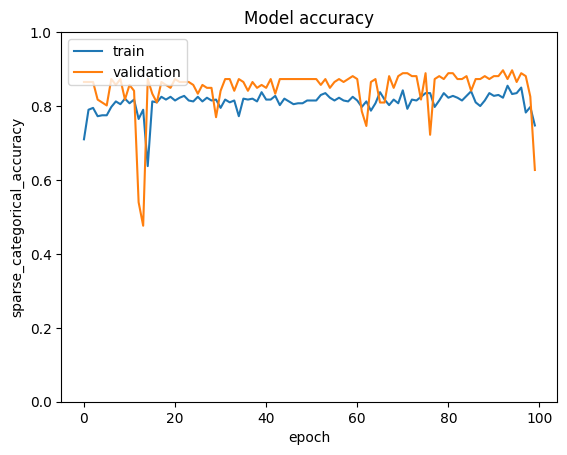

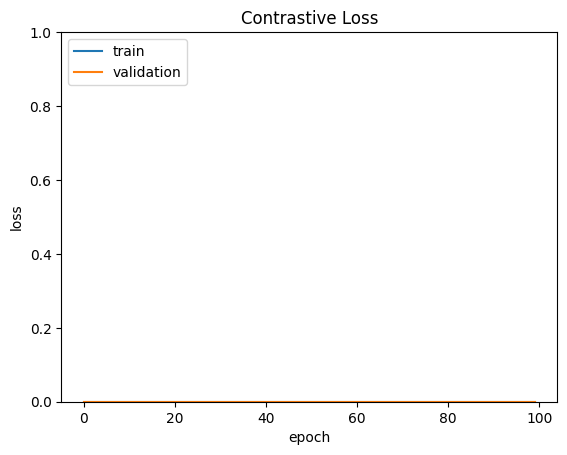

In [10]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.ylim(0, 1)
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="sparse_categorical_accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [11]:
new_data = ass_f
# new_data = test_dataset

# Ensure data is scaled similarly to training data
new_data = new_data / 255.0

# Get the features using the encoder
features = model.encoder(new_data, training=False)

# Predict the class logits using the linear probe
class_logits = model.linear_probe(features, training=False)

# Get the predicted labels
predicted_labels = np.argmax(np.abs(class_logits), axis=1)

print("Predicted Labels:", predicted_labels)

Predicted Labels: [0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0
 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0]


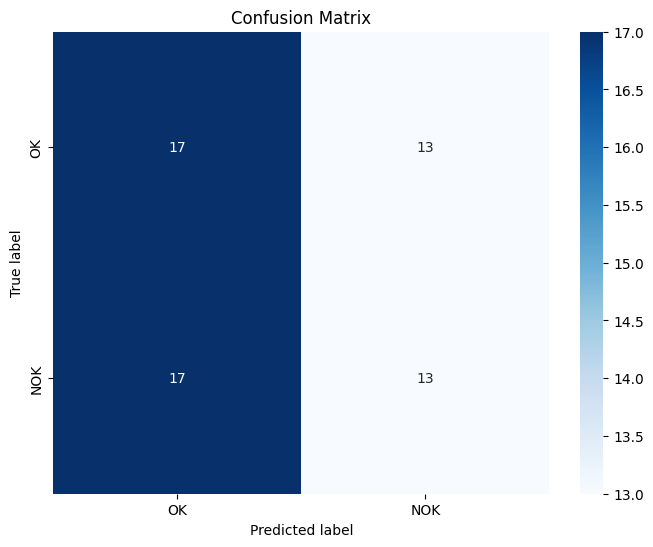

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
#  Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ass_l, predicted_labels), annot=True, fmt="d", cmap="Blues", xticklabels=['OK', 'NOK'], yticklabels=['OK', 'NOK'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()